# NLP EDA

Basically, exploration and modeling boil down to a single question:

How do we quantify our data/text

In this lesson, we'll explore answers to this question that will aid in visualization.

- word frequency (by label)
- ngrams
- word cloud
- sentiment analysis
- other common features

## Setup

Data is spam/ham text messages.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import unicodedata

import re

import env

In [2]:
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-darkgrid')

In [3]:
def clean(text):
    '''Simplified text cleaning function'''
    text = text.lower()
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return re.sub(r"[^a-z0-9\s]", '', text)

In [11]:
#acquire data from spam_db

from env import user, password, host

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_csv('spam_clean.csv')#, index_col = 'id')

# df = pd.read_sql(sql, url, index_col = "id")
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# pd.set_option('display.max_colwidth', -1)


In [12]:
# how many spam and ham observations do we have?

df.label.value_counts(normalize = True)

ham     0.865937
spam    0.134063
Name: label, dtype: float64

#### We have an imbalanced dataset, many more `ham` than `spam` for label

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [14]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [15]:
# combine all messages in single string by label

ham_words = clean(' '.join(df[df.label == 'ham'].text))
spam_words = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))

In [20]:
ham_words[:100]

'go until jurong point crazy available only in bugis n great world la e buffet cine there got amore w'

In [21]:
spam_words[:100]

'free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry'

In [26]:
all_words[:100]

'go until jurong point crazy available only in bugis n great world la e buffet cine there got amore w'

## Exploration

Represent text as word frequencies.

In [62]:
ham_freq = pd.Series(ham_words.split()).value_counts(normalize = True)
spam_freq = pd.Series(spam_words.split()).value_counts(normalize = True)
all_freq = pd.Series(all_words.split()).value_counts()

In [63]:
ham_freq.head()

i      0.034141
you    0.027209
to     0.023017
the    0.016559
a      0.015626
dtype: float64

In [64]:
spam_freq.head()

to      0.038991
a       0.021371
call    0.019723
you     0.016312
your    0.014948
dtype: float64

In [65]:
all_freq.head()

i      2350
to     2240
you    2124
a      1431
the    1322
dtype: int64

In [66]:
# concat all frequencies together into a dataframe

word_counts = pd.concat([ham_freq, spam_freq, all_freq], axis=1).fillna(0).astype(float)
# word_counts = pd.concat([ham_freq, spam_freq, all_freq], axis=1).fillna(0.1).astype(int)
word_counts.columns = ['ham', 'spam', 'all']
word_counts.head()

,ham,spam,all
i,0.034141,0.002558,2350.0
you,0.027209,0.016312,2124.0
to,0.023017,0.038991,2240.0
the,0.016559,0.011595,1322.0
a,0.015626,0.021371,1431.0


- What are the most frequently occuring words?
- Are there any words that uniquely identify a spam or ham message? I.e. words present in one type of message but not the other?

In [67]:
# sort by 'all'

word_counts.sort_values('all', ascending=False).head(10)

,ham,spam,all
i,0.034141,0.002558,2350.0
to,0.023017,0.038991,2240.0
you,0.027209,0.016312,2124.0
a,0.015626,0.021371,1431.0
the,0.016559,0.011595,1322.0
u,0.014604,0.008355,1133.0
and,0.012560,0.006934,970.0
is,0.010783,0.008980,886.0
in,0.012012,0.004149,884.0
me,0.011198,0.001705,786.0


In [68]:
# sort by 'ham' and 'spam' columns
word_counts.sort_values(['ham', 'spam'], ascending=[True, False]).head(10)

,ham,spam,all
claim,0.0,0.006423,113.0
prize,0.0,0.005229,92.0
won,0.0,0.004149,73.0
guaranteed,0.0,0.002842,50.0
tone,0.0,0.002728,48.0
18,0.0,0.002444,43.0
awarded,0.0,0.002160,38.0
a1000,0.0,0.001989,35.0
150ppm,0.0,0.001932,34.0
a2000,0.0,0.001762,31.0


### Visualization

- ham vs spam count for 20 most common words
- ham vs spam proportion for 20 most common words

Text(0.5, 1.0, 'Ham vs Spam count for the top 20 most frequent words')

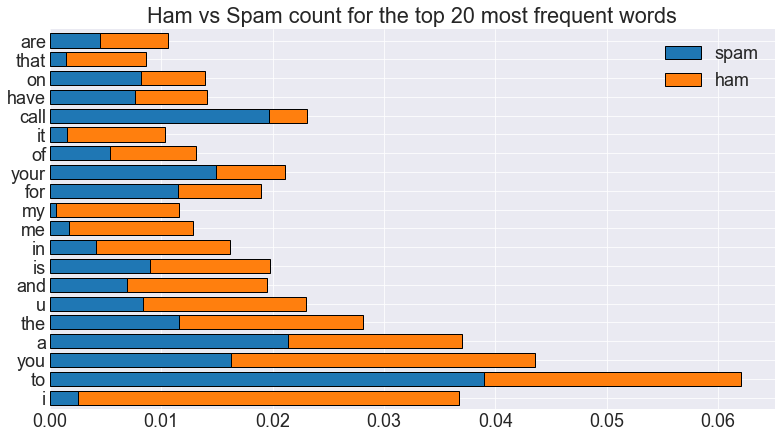

In [69]:
plt.rc('font', size=18)
word_counts.sort_values('all', ascending=False).head(20)[['spam', 'ham']].plot.barh(stacked = True, width = .75,\
                                                                                   ec = 'k')
plt.title('Ham vs Spam count for the top 20 most frequent words')

Text(0.5, 1.0, '% of spam vs ham for the most common 20 words')

<Figure size 1152x648 with 0 Axes>

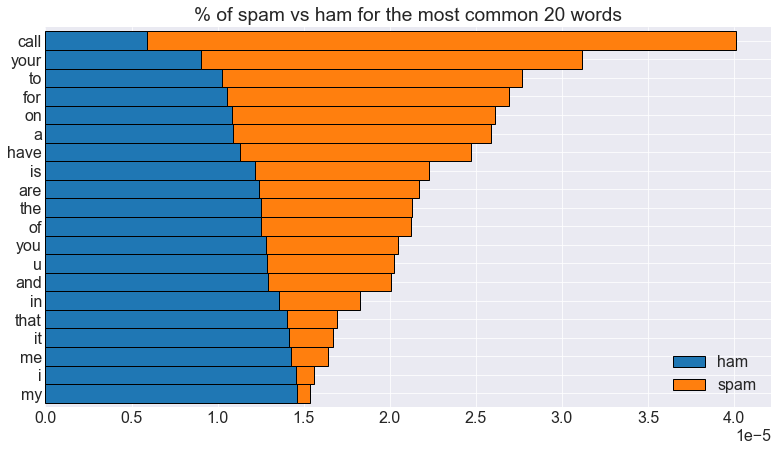

In [70]:
plt.figure(figsize=(16, 9))
plt.rc('font', size=16)

(word_counts.sort_values('all', ascending=False)
 .head(20)
 .apply(lambda row: row/row['all'], axis = 1)
 .drop(columns = 'all')
 .sort_values(by = 'spam')
 .plot.barh(stacked = True, width = 1, ec = 'k')
)
plt.title('% of spam vs ham for the most common 20 words')

## n-grams

**bigram**: combinations of 2 words

Represent text as combinations of 2 words

In [71]:
sentence = 'Today is tuesday, and the weather is nice.'

In [141]:
nltk.bigrams(sentence.split())

<generator object bigrams at 0x7f9c2b086580>

In [72]:
list(nltk.bigrams(sentence.split()))

[('Today', 'is'),
 ('is', 'tuesday,'),
 ('tuesday,', 'and'),
 ('and', 'the'),
 ('the', 'weather'),
 ('weather', 'is'),
 ('is', 'nice.')]

**Be Careful!** Make sure you are making bigrams out of *words*.

In [ ]:
# Don't do this!
# list(nltk.bigrams(sentence))
# make sure you ****.split()**** string first before passing it!

- what are the most common bigrams? spam bigrams? ham bigrams?
- visualize 20 most common bigrams, most common ham bigrams
- ngrams

Find the most common bigram and then find a representative text

<AxesSubplot:>

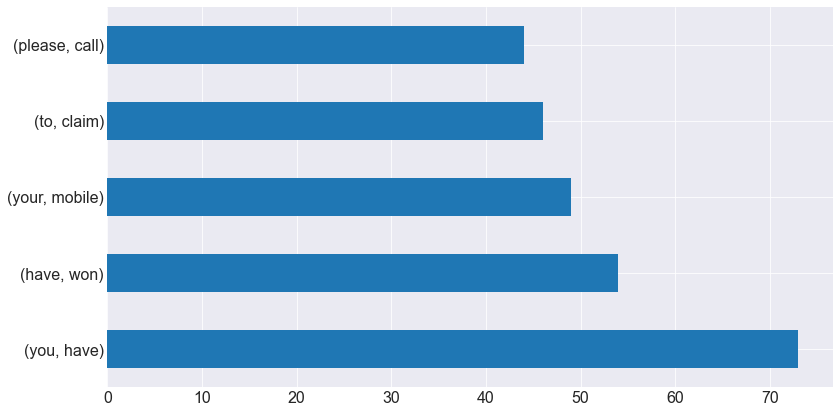

In [82]:
pd.Series(nltk.bigrams(spam_words.split())).value_counts().head().plot.barh()

Text(0.5, 1.0, 'Top 10 most common spam bigrams')

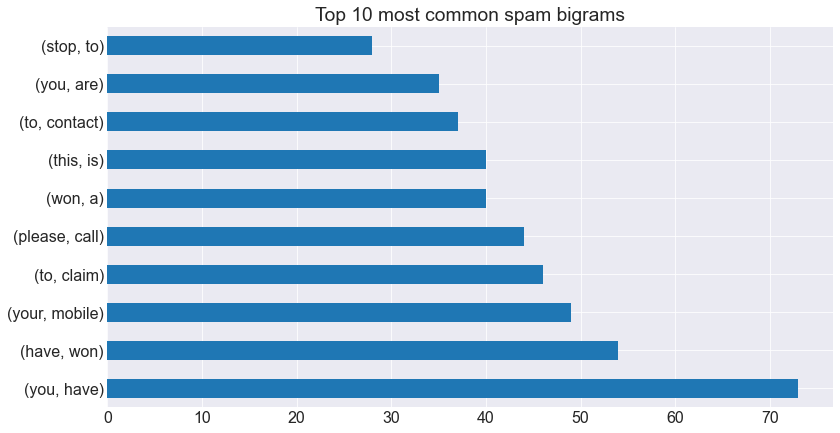

In [73]:
pd.Series(nltk.bigrams(spam_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 most common spam bigrams')

## Word Cloud

`python -m pip install --upgrade wordcloud`

documentation: https://amueller.github.io/word_cloud/

In [143]:
spam_words

'free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry questionstd txt ratetcs apply 08452810075over18s freemsg hey there darling its been 3 weeks now and no word back id like some fun you up for it still tb ok xxx std chgs to send a150 to rcv winner as a valued network customer you have been selected to receivea a900 prize reward to claim call 09061701461 claim code kl341 valid 12 hours only had your mobile 11 months or more u r entitled to update to the latest colour mobiles with camera for free call the mobile update co free on 08002986030 six chances to win cash from 100 to 20000 pounds txt csh11 and send to 87575 cost 150pday 6days 16 tsandcs apply reply hl 4 info urgent you have won a 1 week free membership in our a100000 prize jackpot txt the word claim to no 81010 tc wwwdbuknet lccltd pobox 4403ldnw1a7rw18 xxxmobilemovieclub to use your credit click the wap link in the next txt message or click here httpwap xxxmobilemovieclubcomnqj

(-0.5, 799.5, 599.5, -0.5)

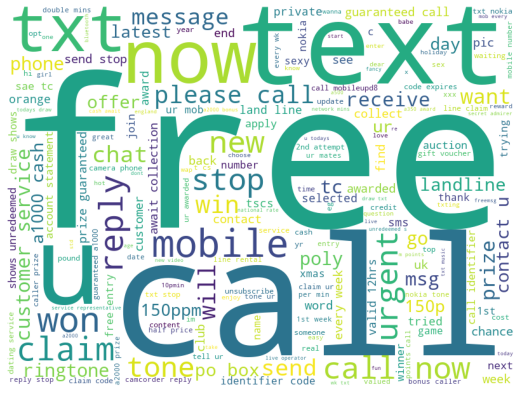

In [84]:
from wordcloud import WordCloud
img = WordCloud(background_color='white', width=800, height=600).generate(spam_words)
plt.imshow(img)
plt.axis('off')

In [85]:
whitney_lyrics = '''
You are the flame in my heart
You light my way in the dark
You are the ultimate star
You lift me from up above
Your unconditional love
Takes me to paradise
I belong to you
And you
You belong to me too
You make my life complete
You make me feel so sweet
You make me feel so divine
Your soul and mind are entwined
Before you I was blind
But since I've opened my eyes
And with you there's no disguise
So I could open up my mind
I always loved you from the start
But I could not figure out
That I had to do it everyday
So I put away the fight
Now I'm gonna live my life
Giving you the most in every way
I belong to you
And you
You belong to me too
You make my life complete
You make me feel so sweet
Oh I belong to you
I belong to you
And you, you
You belong to me too
You make my life complete
You make me feel so sweet
Oh I belong to you
I belong to you
And you, you
You belong to me too
You make my life complete
You make my life complete
You make me feel so sweet
Oh I belong to you
I belong to you
And you, and you
You belong to me too
You make my life complete
You make my life complete
You make me feel so sweet
'''

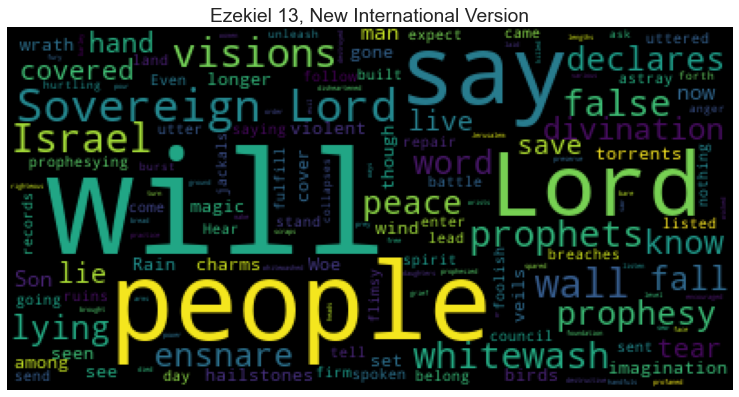

In [140]:
img = WordCloud().generate(eze_13)
plt.imshow(img)
plt.axis('off')
plt.title('Ezekiel 13, New International Version')
plt.show();

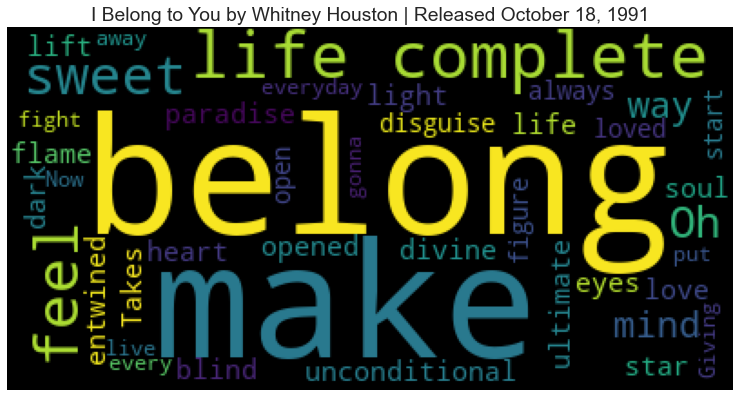

In [89]:
img = WordCloud().generate(whitney_lyrics)
plt.imshow(img)
plt.axis('off')
plt.title('I Belong to You by Whitney Houston | Released October 18, 1991')
plt.show();

## Other Common Features

Any NLP dataset will have domain specific features, for example: number of retweets, number of @mentions, number of upvotes, or mean time to respond to a support chat. In addition to these domain specific features, some common measures for a document are:

- character count
- word count
- sentence count
- stopword count
- unique word count
- punctuation count
- average word length
- average words per sentence
- word to stopword ratio

Create one or more of the above features and visualize it.

In [90]:
# add two new columns 'message_length' and 'word_count'

df['message_length'] = df.text.apply(len)

df['word_count'] = df.text.apply(clean).apply(str.split).apply(len)

df.head()

,label,text,message_length,word_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,20
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28
3,ham,U dun say so early hor... U c already then say...,49,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13


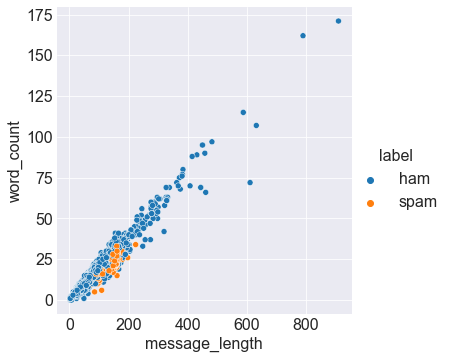

In [91]:
sns.relplot(data = df, x = 'message_length', y = 'word_count', hue = 'label')

<AxesSubplot:ylabel='label'>

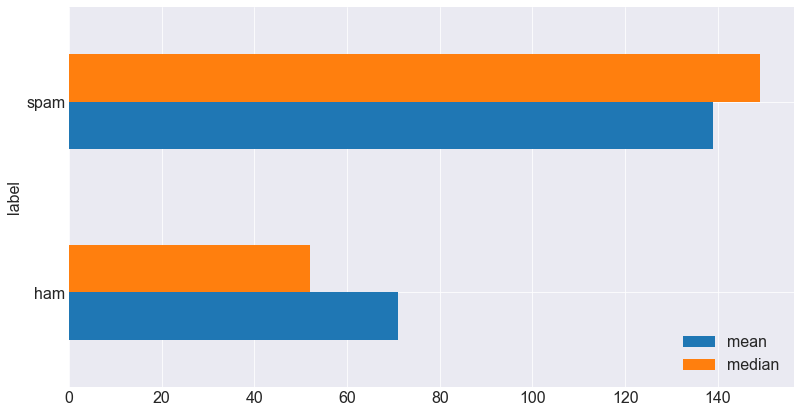

In [96]:
df.groupby('label').message_length.agg(['mean', 'median']).plot.barh()

<AxesSubplot:ylabel='label'>

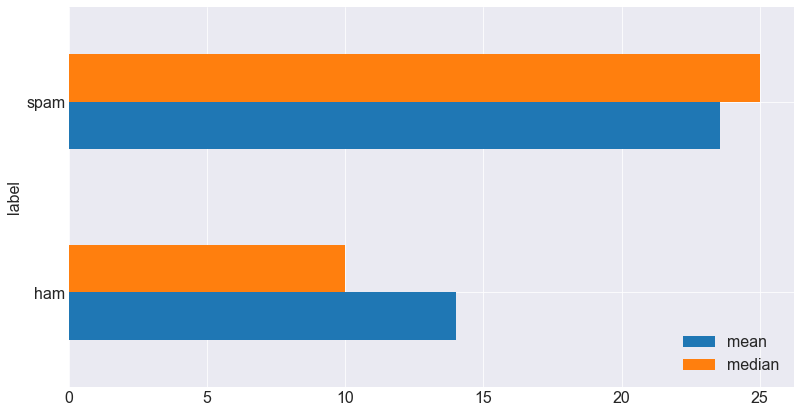

In [98]:
df.groupby('label').word_count.agg(['mean', 'median']).plot.barh()

## Sentiment

A number indicating whether the document is positive or negative.

- knowledge-based + statistical approach
- relies on human-labelled data
    - combination of qualitative and quantitative methods
    - then empirically validate
- different models for diff domains (e.g. social media vs news)
- for social media
    - Afinn ([github](https://github.com/fnielsen/afinn) + [whitepaper](http://www2.imm.dtu.dk/pubdb/edoc/imm6006.pdf))
    - Vader ([github](https://github.com/cjhutto/vaderSentiment) + [whitepaper](http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf)) `nltk.sentiment.vader.SentimentIntensityAnalyzer`.<br> 

Pre-trained sentiment analyzer (**V**alence **A**ware **D**ictionary and s**E**ntiment **R**easoner).)
- best for microblogging, shorter text
- social media posts
- text messages


From your terminal:
`python -c 'import nltk;nltk.download("vader_lexicon")'`

In [99]:
import nltk.sentiment

# creating vader sentiment analyzer object
sia = nltk.sentiment.SentimentIntensityAnalyzer()

# applying object to string
sia.polarity_scores('He is really good')

{'neg': 0.0, 'neu': 0.484, 'pos': 0.516, 'compound': 0.4927}

In [139]:
eze_13 = '''
The word of the Lord came to me: 2 “Son of man, prophesy against the prophets of Israel who are now prophesying. Say to those who prophesy out of their own imagination: ‘Hear the word of the Lord! 3 This is what the Sovereign Lord says: Woe to the foolish[a] prophets who follow their own spirit and have seen nothing! 4 Your prophets, Israel, are like jackals among ruins. 5 You have not gone up to the breaches in the wall to repair it for the people of Israel so that it will stand firm in the battle on the day of the Lord. 6 Their visions are false and their divinations a lie. Even though the Lord has not sent them, they say, “The Lord declares,” and expect him to fulfill their words. 7 Have you not seen false visions and uttered lying divinations when you say, “The Lord declares,” though I have not spoken?

8 “‘Therefore this is what the Sovereign Lord says: Because of your false words and lying visions, I am against you, declares the Sovereign Lord. 9 My hand will be against the prophets who see false visions and utter lying divinations. They will not belong to the council of my people or be listed in the records of Israel, nor will they enter the land of Israel. Then you will know that I am the Sovereign Lord.

10 “‘Because they lead my people astray, saying, “Peace,” when there is no peace, and because, when a flimsy wall is built, they cover it with whitewash, 11 therefore tell those who cover it with whitewash that it is going to fall. Rain will come in torrents, and I will send hailstones hurtling down, and violent winds will burst forth. 12 When the wall collapses, will people not ask you, “Where is the whitewash you covered it with?”

13 “‘Therefore this is what the Sovereign Lord says: In my wrath I will unleash a violent wind, and in my anger hailstones and torrents of rain will fall with destructive fury. 14 I will tear down the wall you have covered with whitewash and will level it to the ground so that its foundation will be laid bare. When it[b] falls, you will be destroyed in it; and you will know that I am the Lord. 15 So I will pour out my wrath against the wall and against those who covered it with whitewash. I will say to you, “The wall is gone and so are those who whitewashed it, 16 those prophets of Israel who prophesied to Jerusalem and saw visions of peace for her when there was no peace, declares the Sovereign Lord.”’

17 “Now, son of man, set your face against the daughters of your people who prophesy out of their own imagination. Prophesy against them 18 and say, ‘This is what the Sovereign Lord says: Woe to the women who sew magic charms on all their wrists and make veils of various lengths for their heads in order to ensnare people. Will you ensnare the lives of my people but preserve your own? 19 You have profaned me among my people for a few handfuls of barley and scraps of bread. By lying to my people, who listen to lies, you have killed those who should not have died and have spared those who should not live.

20 “‘Therefore this is what the Sovereign Lord says: I am against your magic charms with which you ensnare people like birds and I will tear them from your arms; I will set free the people that you ensnare like birds. 21 I will tear off your veils and save my people from your hands, and they will no longer fall prey to your power. Then you will know that I am the Lord. 22 Because you disheartened the righteous with your lies, when I had brought them no grief, and because you encouraged the wicked not to turn from their evil ways and so save their lives, 23 therefore you will no longer see false visions or practice divination. I will save my people from your hands. And then you will know that I am the Lord.’”

'''

In [100]:
sia.polarity_scores(whitney_lyrics)

{'neg': 0.039, 'neu': 0.811, 'pos': 0.149, 'compound': 0.9867}

In [101]:
sia.polarity_scores('He is really good!!!')

{'neg': 0.0, 'neu': 0.424, 'pos': 0.576, 'compound': 0.6211}

In [102]:
sia.polarity_scores('I love you.')

{'neg': 0.0, 'neu': 0.192, 'pos': 0.808, 'compound': 0.6369}

In [105]:
sia.polarity_scores('I LOVE you!')

{'neg': 0.0, 'neu': 0.161, 'pos': 0.839, 'compound': 0.7371}

In [106]:
sia.polarity_scores('I LOVE YOU!')

{'neg': 0.0, 'neu': 0.182, 'pos': 0.818, 'compound': 0.6696}

In [107]:
sia.polarity_scores('He is REALLY good')

{'neg': 0.0, 'neu': 0.433, 'pos': 0.567, 'compound': 0.6028}

In [108]:
sia.polarity_scores('He is very good!!!')

{'neg': 0.0, 'neu': 0.424, 'pos': 0.576, 'compound': 0.6211}

In [109]:
sia.polarity_scores('The food is good but service is slow')

{'neg': 0.0, 'neu': 0.782, 'pos': 0.218, 'compound': 0.2382}

In [110]:
sia.polarity_scores('He is good :-)')

{'neg': 0.0, 'neu': 0.278, 'pos': 0.722, 'compound': 0.6369}

In [111]:
sia.polarity_scores('The food SUX')

{'neg': 0.618, 'neu': 0.382, 'pos': 0.0, 'compound': -0.4995}

Things that can influence Sentiment Score:
1. Punctuations. Can increase the intensity
2. Capitalization. Can increase the intensity
3. Degree modifiers
4. Conjunctions

It can handle Emojis and slangs

Apply this to the text message data

In [113]:
df['sentiment'] = df.text.apply(lambda doc: sia.polarity_scores(doc)['compound'])
df

,label,text,message_length,word_count,sentiment
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,0.6249
1,ham,Ok lar... Joking wif u oni...,29,6,0.4767
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,0.7964
3,ham,U dun say so early hor... U c already then say...,49,11,0.0000
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,-0.1027
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,161,30,0.8805
5568,ham,Will Ì_ b going to esplanade fr home?,37,8,0.0000
5569,ham,"Pity, * was in mood for that. So...any other s...",57,9,-0.2960
5570,ham,The guy did some bitching but I acted like i'd...,125,26,0.8934


<AxesSubplot:ylabel='label'>

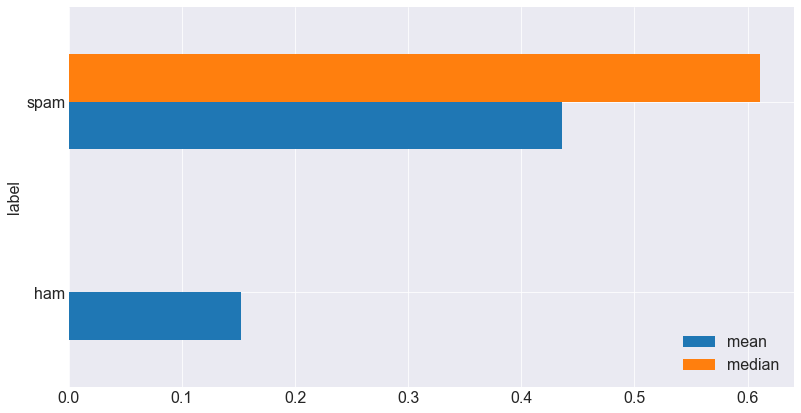

In [118]:
# is the mean and median values of sentiment score different for ham vs spam?
df.groupby('label').sentiment.agg(['mean','median']).plot.barh()

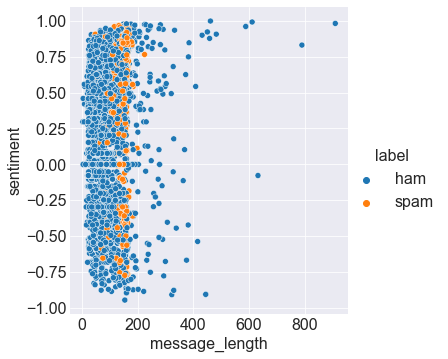

In [115]:
#plot message_length vs sentiment and hue by label
sns.relplot(data = df, x = 'message_length', y = 'sentiment', hue = 'label')

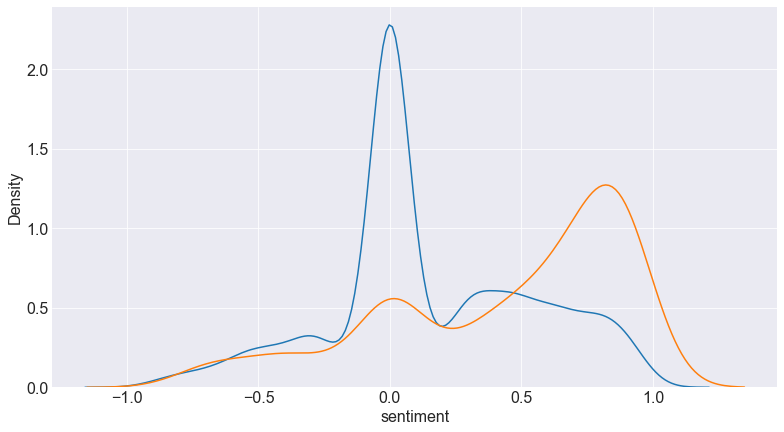

In [119]:
# is the distribution for sentiment different for ham vs spam
sns.kdeplot(df[df.label == 'ham'].sentiment, label = 'ham')
sns.kdeplot(df[df.label == 'spam'].sentiment, label = 'spam');

/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='message_length', ylabel='sentiment'>

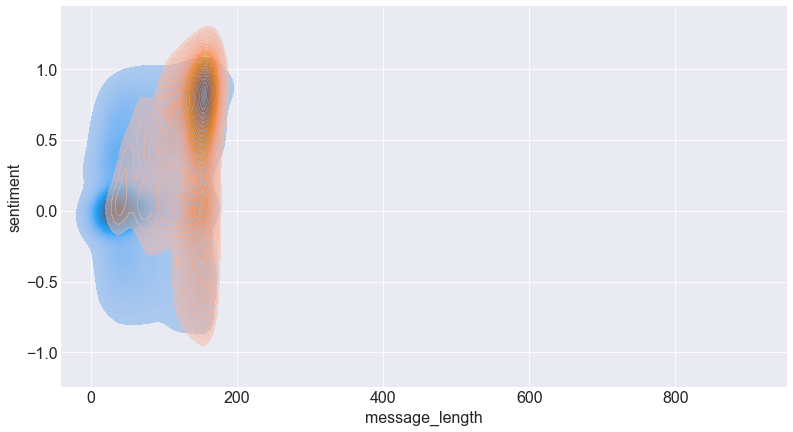

In [120]:
# Bivariate KDE plot for message_length vs sentiment score 
sns.kdeplot(df[df.label == 'ham'].message_length,df[df.label == 'ham'].sentiment, levels = 30, shade = True )
sns.kdeplot(df[df.label == 'spam'].message_length,df[df.label == 'spam'].sentiment, levels = 30, shade = True, alpha = 0.5 )

In [134]:
df.sort_values(by = 'sentiment').head()

,label,text,message_length,word_count,sentiment
297,ham,Hurt me... Tease me... Make me cry... But in the end of my life when i die plz keep one rose on my grave and say STUPID I MISS U.. HAVE A NICE DAY BSLVYL,153,35,-0.9437
4298,ham,Hurt me... Tease me... Make me cry... But in the end of my life when i die plz keep one rose on my grave and say STUPID I MISS U.. HAVE A NICE DAY BSLVYL,153,35,-0.9437
3564,ham,"We know TAJ MAHAL as symbol of love. But the other lesser known facts 1. Mumtaz was Shahjahan's 4th wife, out of his 7 wifes. 2. Shahjahan killed Mumtaz's husband to marry her. 3. Mumtaz died in her &lt;#&gt; th delivery. 4. He then married Mumtaz's sister. Question arises where the Hell is the LOVE?:-| -The Great Hari-",322,58,-0.9062
2680,ham,"Solve d Case : A Man Was Found Murdered On &lt;DECIMAL&gt; . &lt;#&gt; AfterNoon. 1,His wife called Police. 2,Police questioned everyone. 3,Wife: Sir,I was sleeping, when the murder took place. 4.Cook: I was cooking. 5.Gardener: I was picking vegetables. 6.House-Maid: I went 2 d post office. 7.Children: We went 2 play. 8.Neighbour: We went 2 a marriage. Police arrested d murderer Immediately. Who's It? Reply With Reason, If U r Brilliant.",444,69,-0.9042
2407,ham,"Solve d Case : A Man Was Found Murdered On &lt;DECIMAL&gt; . &lt;#&gt; AfterNoon. 1,His wife called Police. 2,Police questioned everyone. 3,Wife: Sir,I was sleeping, when the murder took place. 4.Cook: I was cooking. 5.Gardener: I was picking vegetables. 6.House-Maid: I went 2 d post office. 7.Children: We went 2 play. 8.Neighbour: We went 2 a marriage. Police arrested d murderer Immediately. Who's It? Reply With Reason, If U r Brilliant.",444,69,-0.9042


In [137]:
worst = df.sort_values(by = 'sentiment')['text'].head(1)

In [138]:
# pd.set_option('display.max_colwidth', None)
worst

297    Hurt me... Tease me... Make me cry... But in the end of my life when i die plz keep one rose on my grave and say STUPID I MISS U.. HAVE A NICE DAY BSLVYL
Name: text, dtype: object

## More Resources

- [kaggle wikipedia movie plots](https://www.kaggle.com/jrobischon/wikipedia-movie-plots)
    - Suggestion: narrow to top n genres that aren't unknown
- [wikitable extractor](https://wikitable2csv.ggor.de/) (Try with, e.g. [helicopter prison escapes](https://en.wikipedia.org/wiki/List_of_helicopter_prison_escapes))
- [Textblob library](https://textblob.readthedocs.io/en/dev/)

In [144]:
from PIL import Image